PREGUNTA 3

PASO 1

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Señal observada $x[n]$')

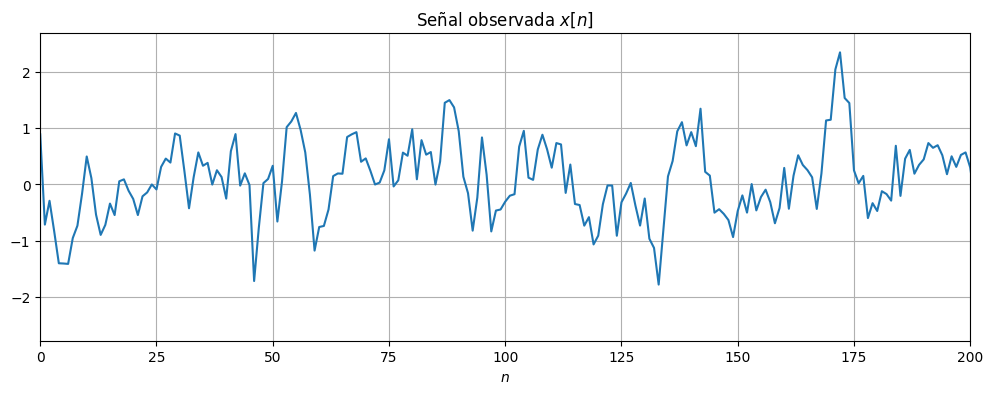

In [3]:
# Generando las señales
N = 2000

# Señal observada x[n] - Proceso Autoregresivo
a = [0.85,-0.15]
b = [1]
varianza = 0.25
x = signal.lfilter(b,[1,-a[0],-a[1]],np.sqrt(varianza) * np.random.randn(N))

plt.figure(figsize=[12,4])
plt.plot(x)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([0,200])
plt.title('Señal observada $x[n]$')


PASO 2

Error medio cuadrático:  0.04721892600800125
Coeficientes [ 0.82402457 -0.13921601]


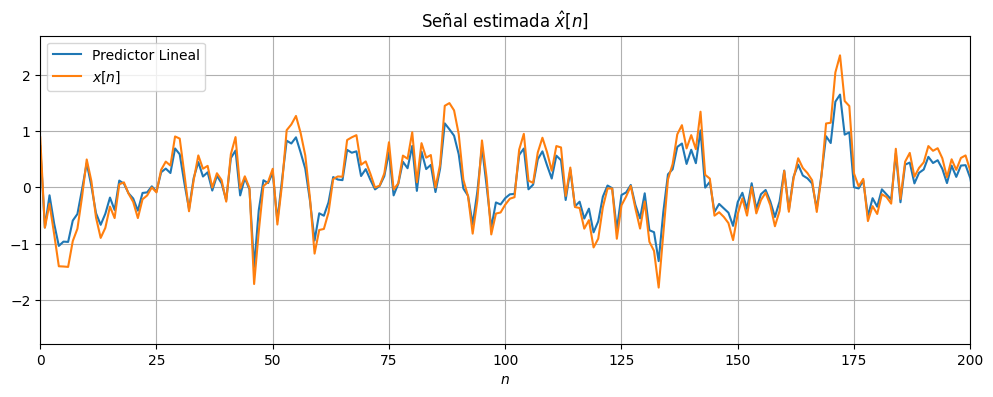

In [4]:
# Wiener Filter

M = 2

# Matriz Rx[i,j] = rx[i-j]
rx = np.zeros(M)
for i in range(M):
    rx[i] = np.mean(x[i:N]*x[0:N-i])
    
Rx = np.zeros((M,M))
for i in range(M):
    for j in range(M):
        Rx[i,j] = rx[np.abs(i-j)]

# Vector rdx[i] = rx[i+1]
rdx = np.zeros(M)
for i in range(M):
    rdx[i] = np.mean(x[(i+1):N]*x[0:N-(i+1)])

# Calculando Filtro Wiener
W = np.dot(np.linalg.inv(Rx),rdx)
x_W = signal.lfilter(W,[1],x)

plt.figure(figsize=[12,4])
plt.plot(x_W)
plt.plot(x)
plt.grid('on')
plt.xlabel('$n$')
plt.xlim([0,200])
#plt.xlim([400,500])
plt.title('Señal estimada $\hat{x}[n]$')
plt.legend(['Predictor Lineal','$x[n]$'])


# Calculando algunos parámetros
print('Error medio cuadrático: ',np.mean((x-x_W)**2))
print('Coeficientes', W)

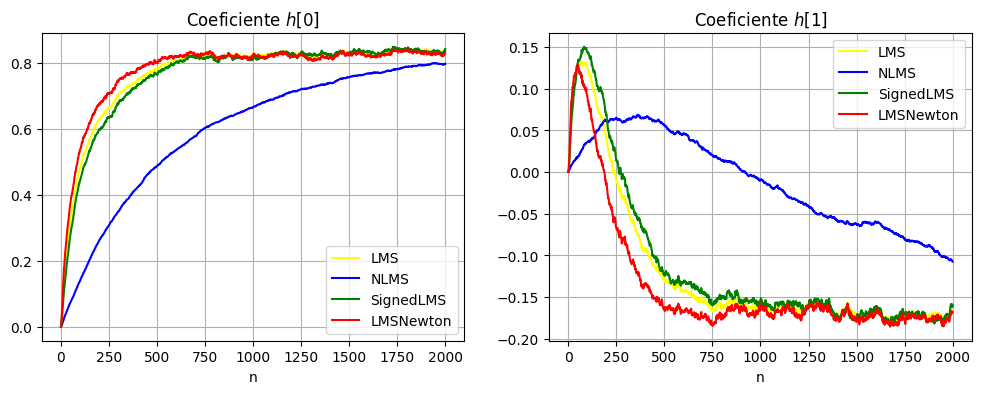

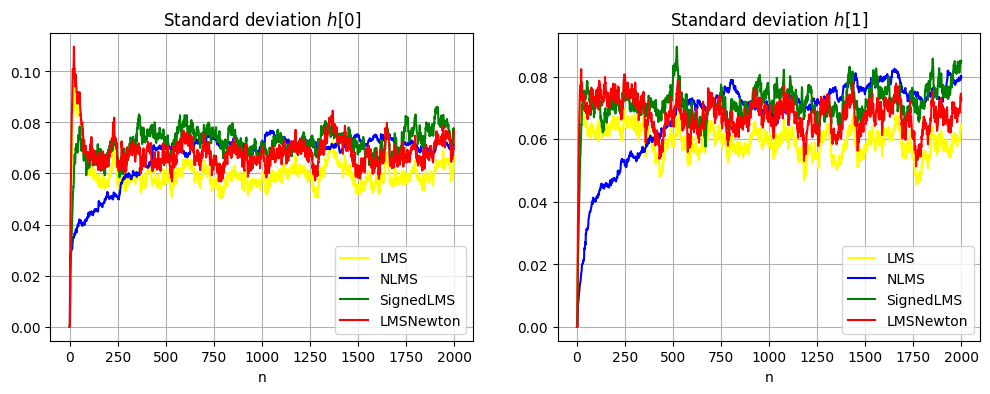

In [5]:
# Implementando filtros adaptivos LMS
#desviación estándar igualada, se compara la velocidad de convergencia de los coeficientes:
L = 100

h_LMS = np.zeros((M,N,L))
d_LMS = np.zeros((N,L))

h_SignedLMS = np.zeros((M, N, L))
d_SignedLMS = np.zeros((N, L))

h_NLMS = np.zeros((M,N,L))
d_NLMS = np.zeros((N,L))

h_LMSNewton = np.zeros((M, N, L))
d_LMSNewton = np.zeros((N, L))


h_LMSNewton = np.zeros((M, N,L))
d_LMSNewton = np.zeros((N,L))


for l in range(L):
    x = signal.lfilter(b,[1,-a[0],-a[1]],np.sqrt(varianza) * np.random.randn(N))

    # Algoritmo Signed-LMS
    mu_SignedLMS = 0.009
    xx = np.zeros(M)
    for n in range(N-1):
        d_SignedLMS[n,l] = np.dot(h_SignedLMS[:,n,l], xx)
        en = x[n] -d_SignedLMS[n,l]
        h_SignedLMS[:,n+1,l] = h_SignedLMS[:,n,l] + 2 * mu_SignedLMS * np.sign(en) * xx
        xx = np.roll(xx,1)
        xx[0] = x[n]

    # Algoritmo LMS
    mu_LMS = 0.015
    xx = np.zeros(M)
    for n in range(N-1):
        d_LMS[n,l] = np.dot(h_LMS[:,n,l],xx)
        en = x[n] - d_LMS[n,l]
        h_LMS[:,n+1,l] = h_LMS[:,n,l] + 2 * mu_LMS * en * xx
        xx = np.roll(xx,1)
        xx[0] = x[n]

    # Algoritmo LMS normalizado
    mu_NLMS = 0.002
    eps_NLMS = 1E-4
    xx = np.zeros(M)
    for n in range(N-1):
        d_NLMS[n,l] = np.dot(h_NLMS[:,n,l],xx)
        en = x[n] - d_NLMS[n,l]
        h_NLMS[:,n+1,l] = h_NLMS[:,n,l] + 2 * mu_NLMS * en * xx / (np.dot(xx,xx)+eps_NLMS)
        xx = np.roll(xx,1)
        xx[0] = x[n]
    
    # Implementing LMS-Newton adaptive filter
    mu_LMSNewton = 0.02
    xx = np.zeros(M)
    R = np.eye(M)
    R_inv = np.linalg.inv(R)
    for n in range(N - 1):
        d_LMSNewton[n,l] = np.dot(h_LMSNewton[:, n,l], xx)
        en = x[n] - d_LMSNewton[n,l]
        R = R - mu_LMSNewton * np.outer(np.dot(R_inv, xx), np.dot(xx, R_inv))
        h_LMSNewton[:, n + 1,l] = h_LMSNewton[:, n,l] + 2 * mu_LMSNewton * np.dot(R_inv, xx) * en
        xx = np.roll(xx, 1)
        xx[0] = x[n]


h_LMS_mean = np.mean(h_LMS,axis=2)
h_SignedLMS_mean = np.mean(h_SignedLMS,axis=2)
h_NLMS_mean = np.mean(h_NLMS,axis=2)
h_LMSNewton_mean = np.mean(h_LMSNewton,axis=2)

h_LMS_var = np.var(h_LMS,axis=2)
h_NLMS_var = np.var(h_NLMS,axis=2)
h_SignedLMS_var = np.var(h_SignedLMS,axis=2)
h_LMSNewton_var = np.var(h_LMSNewton,axis=2)


plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS_mean[0,:],'yellow')
plt.plot(h_NLMS_mean[0,:],'blue')
plt.plot(h_SignedLMS_mean[0,:],'green')
plt.plot(h_LMSNewton_mean[0,:],'red')
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','NLMS','SignedLMS','LMSNewton'])


plt.subplot(1,2,2)
plt.plot(h_LMS_mean[1,:],'yellow')
plt.plot(h_NLMS_mean[1,:],'blue')
plt.plot(h_SignedLMS_mean[1,:],'green')
plt.plot(h_LMSNewton_mean[1,:],'red')
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','NLMS','SignedLMS','LMSNewton'])


plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(np.sqrt(h_LMS_var[0,:]),'yellow')
plt.plot(np.sqrt(h_NLMS_var[0,:]),'blue')
plt.plot(np.sqrt(h_SignedLMS_var[0,:]),'green')
plt.plot(np.sqrt(h_LMSNewton_var[0,:]),'red')
plt.grid('on')
plt.xlabel('n')
plt.title('Standard deviation $h[0]$')
plt.legend(['LMS','NLMS','SignedLMS','LMSNewton'])


plt.subplot(1,2,2)
plt.plot(np.sqrt(h_LMS_var[1,:]),'yellow')
plt.plot(np.sqrt(h_NLMS_var[1,:]),'blue')
plt.plot(np.sqrt(h_SignedLMS_var[1,:]),'green')
plt.plot(np.sqrt(h_LMSNewton_var[1,:]),'red')
plt.grid('on')
plt.xlabel('n')
plt.title('Standard deviation $h[1]$')
plt.legend(['LMS','NLMS','SignedLMS','LMSNewton'])

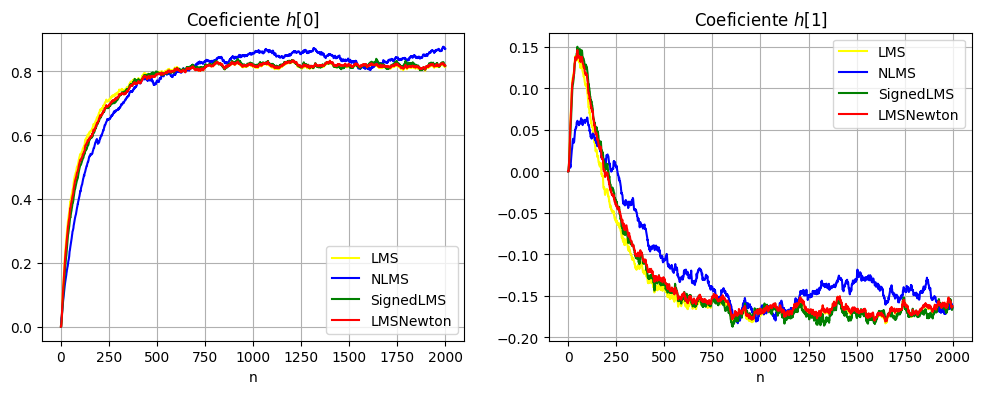

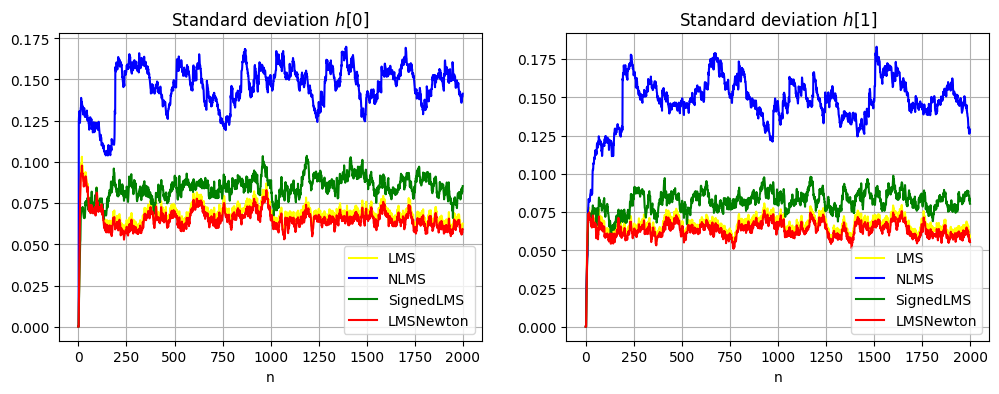

In [6]:
# Implementando filtros adaptivos LMS
#velocidad de convergencia igualada, se compara la desviación estándar:
L = 100

h_LMS = np.zeros((M,N,L))
d_LMS = np.zeros((N,L))

h_SignedLMS = np.zeros((M, N, L))
d_SignedLMS = np.zeros((N, L))

h_NLMS = np.zeros((M,N,L))
d_NLMS = np.zeros((N,L))

h_LMSNewton = np.zeros((M, N, L))
d_LMSNewton = np.zeros((N, L))


h_LMSNewton = np.zeros((M, N,L))
d_LMSNewton = np.zeros((N,L))


for l in range(L):
    x = signal.lfilter(b,[1,-a[0],-a[1]],np.sqrt(varianza) * np.random.randn(N))

    # Algoritmo Signed-LMS
    mu_SignedLMS = 0.012
    xx = np.zeros(M)
    for n in range(N-1):
        d_SignedLMS[n,l] = np.dot(h_SignedLMS[:,n,l], xx)
        en = x[n] -d_SignedLMS[n,l]
        h_SignedLMS[:,n+1,l] = h_SignedLMS[:,n,l] + 2 * mu_SignedLMS * np.sign(en) * xx
        xx = np.roll(xx,1)
        xx[0] = x[n]

    # Algoritmo LMS
    mu_LMS = 0.02
    xx = np.zeros(M)
    for n in range(N-1):
        d_LMS[n,l] = np.dot(h_LMS[:,n,l],xx)
        en = x[n] - d_LMS[n,l]
        h_LMS[:,n+1,l] = h_LMS[:,n,l] + 2 * mu_LMS * en * xx
        xx = np.roll(xx,1)
        xx[0] = x[n]

    # Algoritmo LMS normalizado
    mu_NLMS = 0.008
    eps_NLMS = 1E-4
    xx = np.zeros(M)
    for n in range(N-1):
        d_NLMS[n,l] = np.dot(h_NLMS[:,n,l],xx)
        en = x[n] - d_NLMS[n,l]
        h_NLMS[:,n+1,l] = h_NLMS[:,n,l] + 2 * mu_NLMS * en * xx / (np.dot(xx,xx)+eps_NLMS)
        xx = np.roll(xx,1)
        xx[0] = x[n]
    
    # Implementing LMS-Newton adaptive filter
    mu_LMSNewton = 0.018
    xx = np.zeros(M)
    R = np.eye(M)
    R_inv = np.linalg.inv(R)
    for n in range(N - 1):
        d_LMSNewton[n,l] = np.dot(h_LMSNewton[:, n,l], xx)
        en = x[n] - d_LMSNewton[n,l]
        R = R - mu_LMSNewton * np.outer(np.dot(R_inv, xx), np.dot(xx, R_inv))
        h_LMSNewton[:, n + 1,l] = h_LMSNewton[:, n,l] + 2 * mu_LMSNewton * np.dot(R_inv, xx) * en
        xx = np.roll(xx, 1)
        xx[0] = x[n]


h_LMS_mean = np.mean(h_LMS,axis=2)
h_SignedLMS_mean = np.mean(h_SignedLMS,axis=2)
h_NLMS_mean = np.mean(h_NLMS,axis=2)
h_LMSNewton_mean = np.mean(h_LMSNewton,axis=2)

h_LMS_var = np.var(h_LMS,axis=2)
h_NLMS_var = np.var(h_NLMS,axis=2)
h_SignedLMS_var = np.var(h_SignedLMS,axis=2)
h_LMSNewton_var = np.var(h_LMSNewton,axis=2)


plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(h_LMS_mean[0,:],'yellow')
plt.plot(h_NLMS_mean[0,:],'blue')
plt.plot(h_SignedLMS_mean[0,:],'green')
plt.plot(h_LMSNewton_mean[0,:],'red')
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[0]$')
plt.legend(['LMS','NLMS','SignedLMS','LMSNewton'])


plt.subplot(1,2,2)
plt.plot(h_LMS_mean[1,:],'yellow')
plt.plot(h_NLMS_mean[1,:],'blue')
plt.plot(h_SignedLMS_mean[1,:],'green')
plt.plot(h_LMSNewton_mean[1,:],'red')
plt.grid('on')
plt.xlabel('n')
plt.title('Coeficiente $h[1]$')
plt.legend(['LMS','NLMS','SignedLMS','LMSNewton'])


plt.figure(figsize=[12,4])
plt.subplot(1,2,1)
plt.plot(np.sqrt(h_LMS_var[0,:]),'yellow')
plt.plot(np.sqrt(h_NLMS_var[0,:]),'blue')
plt.plot(np.sqrt(h_SignedLMS_var[0,:]),'green')
plt.plot(np.sqrt(h_LMSNewton_var[0,:]),'red')
plt.grid('on')
plt.xlabel('n')
plt.title('Standard deviation $h[0]$')
plt.legend(['LMS','NLMS','SignedLMS','LMSNewton'])


plt.subplot(1,2,2)
plt.plot(np.sqrt(h_LMS_var[1,:]),'yellow')
plt.plot(np.sqrt(h_NLMS_var[1,:]),'blue')
plt.plot(np.sqrt(h_SignedLMS_var[1,:]),'green')
plt.plot(np.sqrt(h_LMSNewton_var[1,:]),'red')
plt.grid('on')
plt.xlabel('n')
plt.title('Standard deviation $h[1]$')
plt.legend(['LMS','NLMS','SignedLMS','LMSNewton'])